### CS2101 - Programming for Science and Finance
Prof. Götz Pfeiffer<br />
School of Mathematical and Statistical Sciences<br />
University of Galway

***

# Week 7: Transformations

## Linear Transformations

* In this notebook we will look at **linear transformations** of images.
* Instead of manipulating the colour intensities in each pixel, we shall now move the pixels around.
* Examples that we have already seen are flips along the $x$-axis and along the $y$-axis, but we shall see examples of other kinds of transformations shortly. 

In [2]:
import numpy as np
from PIL import Image

(201, 1000, 3)


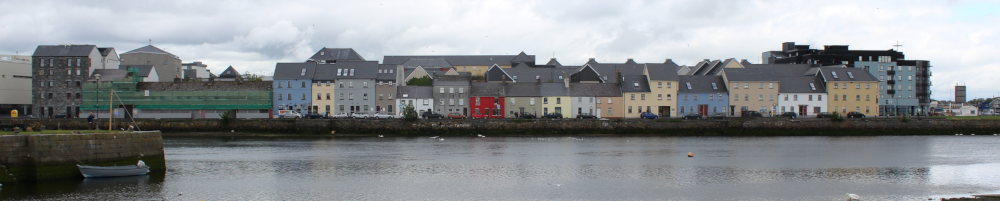

In [3]:
img = Image.open('images/long_walk.png')
pic = np.asarray(img)
print(pic.shape)
Image.fromarray(pic)

* Let us extract a square part of the image. Say 201 by 201 pixels.

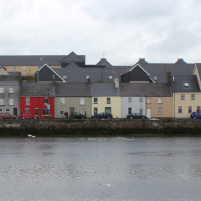

In [4]:
part = pic[:,450:651,:]
Image.fromarray(part)

## Rotations

* The **matrix** $R$ of a **counter-clockwise rotation** by an angle $\alpha$ about the origin $(0,0)$ of the $x, y$-coordinate plane has the form
  $$
  R = \left(\begin{array}{cc}
  \cos \alpha & -\sin \alpha \\ \sin \alpha & \cos \alpha
  \end{array}\right).
  $$
* It maps a point $(x, y)$ to the point
  $$
  R \left(\begin{array}{c}
  x \\ y
  \end{array}\right) =
  \left(\begin{array}{cc}
  \cos \alpha & -\sin \alpha \\ \sin \alpha & \cos \alpha
  \end{array}\right)\left(\begin{array}{c}
  x \\ y
  \end{array}\right)
  =
  \left(\begin{array}{c}
  x \cos \alpha - y \sin \alpha \\ x \sin \alpha + y \cos \alpha
  \end{array}\right).
  $$
* Let's check with numpy.

In [ ]:
from math import pi, sin, cos
alpha = pi/4
rot = np.array([[cos(alpha), -sin(alpha)],[sin(alpha), cos(alpha)]])
rot

In [ ]:
from math import sqrt
1/sqrt(2)

* Where are the standard basis vectors rotated to?

In [ ]:
e0 = np.array([1,0])
e1 = np.array([0,1])

* Recall that Numpy uses the symbol `@` for matrix multiplication.

In [ ]:
rot @ e0

In [ ]:
rot @ e1

In [ ]:
rot @ rot @ e0

## Rotating an Image

* First we **rotate** by going through the source image pixel by pixel and filling out the corresponding rotated pixel in the target. (Later we will do it the other way round).
* We are using `r` and `c` to denote the row and column in the picture - i.e. the coordinate system shown above:
  * `r` starts at 0 the top and increases downwards,
  * and `c` starts at `0` at the left and increases rightwards.
* The coordinates `x` and `y` are in a **standard coordinate system** with the **origin at the center** pixel of the image.
* We have to convert between $(r, c)$ and $(x, y)$ before applying the **transformation matrix**.

In [ ]:
def xy_rc(N, r, c):
    return c - N, N - r

In [ ]:
def rc_xy(N, x, y):
    return N - y, x + N

In [ ]:
alpha = pi/6
source = part
target = np.zeros(part.shape, dtype = np.uint8)
N = source.shape[0]//2

* Now **loop** through the pixels of the source image.
* Some pixels may have been rotated outside of the image array
* So we need to check that their new position is valid before saving the values in the target array.

In [ ]:
for r in range(source.shape[0]):
    for c in range(source.shape[1]):
        x, y = xy_rc(N, r, c)

        # rotation
        x1 = int(x*cos(alpha) - y*sin(alpha))
        y1 = int(x*sin(alpha) + y*cos(alpha))

        r1, c1 = rc_xy(N, x1, y1)

        # check validity of new position
        if 0 <= r1 < target.shape[0] and 0 <= c1 < target.shape[1]:
            target[r1,c1,:] = source[r,c,:]       

In [ ]:
Image.fromarray(target)

* The result looks kind of OK -- but some pixels seem to be missing.
* That's why we will do it 'backwards': iterating over the pixels in the **target** image.
* By doing that, we make sure that every pixel in the relevant area of the target image is filled with an appropriate value.

In [ ]:
# let's try to rotate:
alpha = pi/12
source = part
target = np.zeros(part.shape, dtype = np.uint8)
N = source.shape[0]//2

In [ ]:
# loop through the pixels of the target image.
for r in range(target.shape[0]):
    for c in range(target.shape[1]):
        x, y = xy_rc(N, r, c)
        
        # compute the inverse image of this. multiply by the inverse of the rotation matrix!!
        x1 = int(x*cos(alpha) + y*sin(alpha))
        y1 = int(-x*sin(alpha) + y*cos(alpha))

        r1, c1 = rc_xy(N, x1, y1)

        # only save pixels that are inside the appropriate bounds for the array
        if 0 <= r1 < source.shape[0] and 0 <= c1 < source.shape[1]:
            target[r,c,:] = source[r1,c1,:]
        

In [ ]:
Image.fromarray(target)

* Much better!

* The code we just wrote works for all kinds of invertible linear transformations, not just rotations.
* We should now write a **function** to do this.

In [ ]:
def lin_trans_im(image, arr):
    """apply a linear transformation.
    image is a numpy array with dtype uint8 representing an image.
    arr is an invertible 2x2 matrix"""

    target = np.zeros(image.shape, dtype = np.uint8)
    N = image.shape[0]//2
    M = image.shape[1]//2

    # compute the inverse of arr
    arr1 = np.linalg.inv(arr)
    
    # loop through the pixels of the target image.
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            # now. First change the the (r,c) to (x,y) where the
            # middle pixel has (x,y)-coordinates (0,0)
            x, y = xy_rc(N, r, c)
            # now compute the inverse image of this. multiply by the inverse of arr!!  
            x1 = int(x*arr1[0,0] + y*arr1[0,1])
            y1 = int(x*arr1[1,0] + y*arr1[1,1])
            # compute the indices in the source image
            r1, c1 = rc_xy(N, x1, y1)

            if 0 <= r1 < image.shape[0] and 0 <= c1 < image.shape[1]:
                target[r,c,:] = image[r1,c1,:]
    return target

* Questions on this code:
  * Is there a more direct way to make an array of zeros, with shape and type of `image`?
  * Can `N`, `M` be found by simultaneous assignment?
  * What was the formula for the inverse of a $2 \times 2$ matrix?
  * Can one use matrix multiplication to find $x_1, y_1$?

In [ ]:
rot = np.array([cos(alpha),-sin(alpha),sin(alpha),cos(alpha)]).reshape(2,2)
rot

In [ ]:
rotim = lin_trans_im(part,rot)

In [1]:
Image.fromarray(rotim)

NameError: name 'Image' is not defined

## Reflections

The matrix for a reflection in a line through the origin with angle $\alpha$ to the $x$-axis is given by
$$
\begin{pmatrix}
\cos 2\alpha & \sin 2\alpha \\
\sin 2\alpha & -\cos 2\alpha
\end{pmatrix}
$$

We'll try that as well, with an angle of 45 degrees ( $ = \pi/4$).

In [ ]:
alpha = pi/4
refl = np.array([cos(2*alpha), sin(2*alpha), sin(2*alpha), -cos(2*alpha)]).reshape(2,2)
reflim = lin_trans_im(part,refl)

In [ ]:
Image.fromarray(reflim)

We can express a horizontal flip (a reflection in the $y$-axis) with the matrix
$$
\begin{pmatrix}
-1 & 0 \\
0 & 1
\end{pmatrix}
$$

In [ ]:
flip = np.array([-1,0,0,1]).reshape((2,2))
flipim = lin_trans_im(part, flip)

In [ ]:
Image.fromarray(flipim)

## References

* Rotation ([wikipedia](https://en.wikipedia.org/wiki/Rotation_matrix))
* Reflection ([wikipedia](https://en.wikipedia.org/wiki/Reflection_(mathematics)))

### `python`

### `numpy`

## Exercises